# GraphRAG

GraphRAG는 기존 RAG 시스템의 한계를 극복하고 더 정교한 정보 검색과 생성을 가능하게 하는 새로운 접근 방식

그래프 데이터 == 지식 그래프 데이터를 뜻하며, 노드와 엣지로 표현한 데이터
- 노드: Entity
- 엣지: 개체 관의 관계



### 기존 RAG 와 차이점

1. GraphRAG는 단순한 벡터 유사도 검색을 넘어서 복잡한 관계와 맥락을 포착할 수 있도록 해 준다.
2. GraphRAG는 전체 데이터셋에 대한 개선된 종합적인 추론 및 요약 능력을 갖추고 있다.
3. 응답 생성 시 출처 정보를 함께 제공하여 AI 서비스 결과의 신뢰성과 검증성을 높인다.

### GraphRAG 를 위한 환경 설정

Neo4j
- 대표적인 Graph Database

In [4]:
!pip install -U langchain langchain_openai neo4j langchain-community

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_community.graphs import Neo4jGraph
import matplotlib.pyplot as plt
import networkx as nx

# Neo4jGraph 객체 사용
# neo4j Bolt URL, Username, Password를 입력하세요 #예시
# sandbox.neo4j.com 에서 생성
# graph = Neo4jGraph(url= "bolt://10.233.38.130:7687" , username="neo4j", password="test1234")
graph = Neo4jGraph(url= "bolt://10.233.82.145:7687" , username="neo4j", password="test1234")

/tmp/ipykernel_1105465/2175693132.py:9: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  graph = Neo4jGraph(url= "bolt://10.233.82.145:7687" , username="neo4j", password="test1234")


In [18]:
# 스키마 가져오기
query = """
CALL db.schema.visualization;
"""
results = graph.query(query)

# 결과 구조 확인
print("Results structure:", results)


Results structure: [{'nodes': [{'name': 'Answer', 'indexes': [], 'constraints': ["Constraint( id=10, name='constraint_7e29bbac', type='UNIQUENESS', schema=(:Answer {uuid}), ownedIndex=9 )"]}, {'name': 'Comment', 'indexes': [], 'constraints': ["Constraint( id=12, name='constraint_32ea8862', type='UNIQUENESS', schema=(:Comment {uuid}), ownedIndex=11 )"]}, {'name': 'User', 'indexes': [], 'constraints': ["Constraint( id=8, name='constraint_b13a3b7d', type='UNIQUENESS', schema=(:User {uuid}), ownedIndex=7 )"]}, {'name': 'Question', 'indexes': [], 'constraints': ["Constraint( id=4, name='constraint_401df8db', type='UNIQUENESS', schema=(:Question {uuid}), ownedIndex=3 )"]}, {'name': 'Tag', 'indexes': [], 'constraints': ["Constraint( id=6, name='constraint_64b1b1cf', type='UNIQUENESS', schema=(:Tag {name}), ownedIndex=5 )"]}], 'relationships': [({'name': 'Question', 'indexes': [], 'constraints': ["Constraint( id=4, name='constraint_401df8db', type='UNIQUENESS', schema=(:Question {uuid}), owned

/tmp/ipykernel_399305/3284610839.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


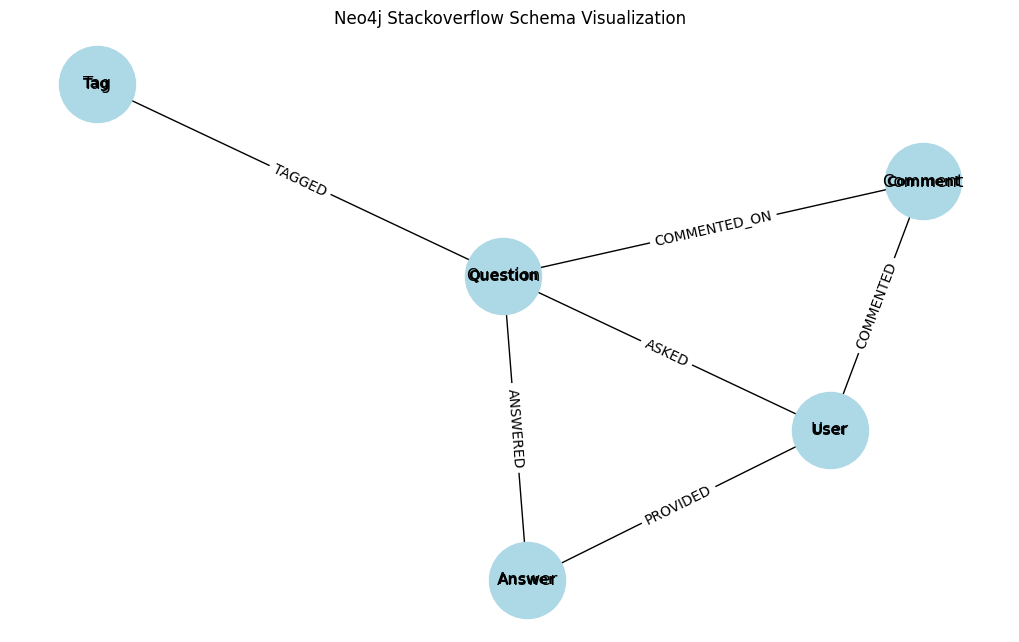

In [19]:
# NetworkX 그래프 생성
G = nx.Graph()

# 결과가 리스트의 딕셔너리 형태로 반환됨
for result in results:
    # 노드 추가
    for node in result['nodes']:
        G.add_node(node['name'], name=node['name'])

    # 엣지 추가
    for rel in result['relationships']:
        start_node = rel[0]['name']
        end_node = rel[2]['name']
        rel_type = rel[1]
        G.add_edge(start_node, end_node, name=rel_type)

# 그래프 레이아웃 설정
pos = nx.spring_layout(G)

# 그래프 그리기
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold')

# 엣지 레이블 추가
edge_labels = nx.get_edge_attributes(G, 'name')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# 노드 레이블 추가
node_labels = nx.get_node_attributes(G, 'name')
nx.draw_networkx_labels(G, pos, node_labels, font_size=12)

plt.title("Neo4j Stackoverflow Schema Visualization")
plt.axis('off')
plt.tight_layout()
plt.show()

#### Neo4j

정형 데이터를 처리하는 대표 언어인 SQL과 달리, 그래프 데이터는 각 데이터베이스마다 고유한 쿼리 언어 및 데이터 구조에 대한 이해가 필요하다.

Neo4j 의 경우 Cypher 라는 언어 외에도 Apached에서 지원하는 Gremlin, API쿼리 언어로 사용되는 GraphQL 등을 지원한다.

여기서는 Cypher 쿼리를 직접 수행해보면서 살펴보자.

In [20]:
# MATCH 절: 그래프 패턴을 지정
# WHERE 절: 조건을 지정
# RETURN 절: 결과를 반환
# ORDER BY 절: 결과를 정렬
# LIMIT 절: 결과의 수를 제한

result = graph.query("""
MATCH (u:User)
WHERE  u.display_name CONTAINS 'ch'
RETURN
    u.display_name AS DisplayName
ORDER BY u.display_name DESC
LIMIT 3""")

print(result)

[{'DisplayName': 'vyaches'}, {'DisplayName': 'vasant kumar chinnipilli'}, {'DisplayName': 'tzach'}]


In [21]:
# 그래프 내부 고유 노드 레이블(DISTINCT) 조회
result = graph.query("""
MATCH (n)
RETURN
    DISTINCT labels(n) AS Labels
LIMIT 100""")
print(result)

[{'Labels': ['Question']}, {'Labels': ['User']}, {'Labels': ['Tag']}, {'Labels': ['Answer']}, {'Labels': ['Comment']}]


In [23]:
# ‘User’ 노드ID 카운트
result = graph.query("""
MATCH (n:User)
WITH
    count(DISTINCT id(n)) AS Node_Unique_Count
RETURN
    Node_Unique_Count """)
print(result)

[{'Node_Unique_Count': 1365}]


In [25]:
# ‘User’ 노드 1개 살펴보기
result = graph.query("""
MATCH (n:User)
RETURN
    id(n) AS NodeID,
    labels(n) AS Labels,
    keys(n) AS key,
    properties(n) AS Properties,
    size(keys(n)) AS PropertyCount
LIMIT 1 """)
print(result)

[{'NodeID': 604, 'Labels': ['User'], 'key': ['uuid', 'display_name'], 'Properties': {'display_name': 'schernichkin', 'uuid': 2236092}, 'PropertyCount': 2}]


<hr></hr>

#### 실습 1) 랭체인의 GraphCypherQAChain을 활용하여 그래프 데이터베이스에 대해 자연어로 쿼리하고 조작하는 방법

In [ ]:
from langchain_community.graphs import Neo4jGraph
import matplotlib.pyplot as plt
import networkx as nx

# Neo4jGraph 객체 사용
# neo4j Bolt URL, Username, Password를 입력하세요 #예시
# sandbox.neo4j.com 에서 생성
# graph = Neo4jGraph(url= "bolt://10.233.38.130:7687" , username="neo4j", password="test1234")
graph = Neo4jGraph(url= "bolt://10.233.82.145:7687" , username="neo4j", password="test1234")

In [ ]:
from langchain.chains import GraphCypherQAChain
from langchain_openai import ChatOpenAI
from langchain_community.graphs import Neo4jGraph


# 질문하기 
chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0), model="gpt-4o-mini", graph=graph, verbose=True, allow_dangerous_requests=True
)
chain.invoke("누가 가장 많이 답변을 달았어? 답변 횟수도 같이 알려줘.")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (u:User)-[:PROVIDED]->(a:Answer)
WITH u, COUNT(a) AS answerCount
RETURN u.display_name, answerCount
ORDER BY answerCount DESC
LIMIT 1;
Full Context:
[{'u.display_name': 'cybersam', 'answerCount': 211}]

> Finished chain.


{'query': '누가 가장 많이 답변을 달았어? 답변 횟수도 같이 알려줘.',
 'result': 'cybersam이(가) 211번의 답변을 작성했어.'}

In [5]:
chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0.5, model="gpt-4"), # gpt-4 모델 설정
    graph=graph,
    verbose=True,
    return_intermediate_steps=True,
    allow_dangerous_requests=True
)

chain.invoke("유저간의 상호작용을 분석하여 서로의 질문에 가장 자주 답변한 사용자 쌍을 찾아줘. 그리고 그 둘의 질문과 답변의 평균 점수도 출력해줘")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (u1:User)-[:ASKED]->(q:Question)<-[:ANSWERED]-(a:Answer)<-[:PROVIDED]-(u2:User)
WITH u1, u2, COUNT(a) AS answers, AVG(a.score) AS avg_answer_score, AVG(q.view_count) AS avg_question_score
ORDER BY answers DESC
RETURN u1.display_name AS user1, u2.display_name AS user2, answers, avg_answer_score, avg_question_score
LIMIT 1;
Full Context:
[{'user1': 'A. L', 'user2': 'Graphileon', 'answers': 5, 'avg_answer_score': 1.0, 'avg_question_score': 59.0}]

> Finished chain.


{'query': '유저간의 상호작용을 분석하여 서로의 질문에 가장 자주 답변한 사용자 쌍을 찾아줘. 그리고 그 둘의 질문과 답변의 평균 점수도 출력해줘',
 'result': '사용자 A. L과 Graphileon이 가장 자주 서로의 질문에 답변을 하였습니다. 그들의 평균 답변 점수는 1.0이고, 평균 질문 점수는 59.0입니다.',
 'intermediate_steps': [{'query': 'MATCH (u1:User)-[:ASKED]->(q:Question)<-[:ANSWERED]-(a:Answer)<-[:PROVIDED]-(u2:User)\nWITH u1, u2, COUNT(a) AS answers, AVG(a.score) AS avg_answer_score, AVG(q.view_count) AS avg_question_score\nORDER BY answers DESC\nRETURN u1.display_name AS user1, u2.display_name AS user2, answers, avg_answer_score, avg_question_score\nLIMIT 1;'},
  {'context': [{'user1': 'A. L',
     'user2': 'Graphileon',
     'answers': 5,
     'avg_answer_score': 1.0,
     'avg_question_score': 59.0}]}]}

In [6]:
# 그래프 노드, 관계 추가하기

result = chain.invoke("GraphRAG 단어가 포함된 질문을 남긴 유저는 누구야?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (u:User)-[:ASKED]->(q:Question)
WHERE q.title CONTAINS 'GraphRAG'
RETURN u.display_name
Full Context:
[]

> Finished chain.


In [7]:
chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0.5, model="gpt-4o"), # gpt-4o 모델 설정
    graph=graph,
    verbose=True,
    return_intermediate_steps=True,
    allow_dangerous_requests=True
)

result = chain.invoke("'Gavin' 이라는 유저와 이 유저의 'What is GraphRAG?'라는 질문을 그래프에 추가해줘")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MERGE (u:User {display_name: 'Gavin'})
MERGE (q:Question {title: 'What is GraphRAG?'})
MERGE (u)-[:ASKED]->(q)

Full Context:
[]

> Finished chain.


In [8]:
result = chain.invoke("GraphRAG 단어가 포함된 질문을 남긴 유저는 누구야?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (u:User)-[:ASKED]->(q:Question)
WHERE q.title CONTAINS 'GraphRAG'
RETURN u.display_name

Full Context:
[{'u.display_name': 'Gavin'}]

> Finished chain.


#### LLM 기반 지식그래프 구축 및 RAG 실습

In [12]:
!pip install yfiles_jupyter_graphs # 노트북에서 그래프 데이터를 시각화하기 위한 라이브러리
!pip install PyPDF2 # pdf 파일을 파싱하고 조작

In [2]:
import os
from langchain_core.runnables import  RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
from PyPDF2 import PdfReader

/home/haiqv/conda/envs/rag/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# DB 연결 체크

from neo4j import GraphDatabase

#neo4j aura   : https://workspace-preview.neo4j.io/workspace/query?code=v1kkRwBrrKaMQfEQDTN96KNVX7UVqqQTonY8uKc9tE8Rm&state=f2416a49214041fc89f73ce3f58d30cf
# bolt://10.233.82.145:7687

# 연결 정보 설정  #예시 
# uri ="neo4j+s://03003836.databases.neo4j.io"
uri ="bolt://10.233.82.179:7687"
user = "neo4j"  # 기본 사용자 이름은 'neo4j'입니다
password = "test1234"  # AuraDB에서 제공한 비밀번호를 입력하세요

# 드라이버 생성
driver = GraphDatabase.driver(uri, auth=(user, password))
# 연결 테스트
def test_connection(tx):
    result = tx.run("RETURN 1 AS num")
    return result.single()["num"]

with driver.session() as session:
    try:
        result = session.read_transaction(test_connection)
        print(f"neo4j 연결 성공: {result}")
    except Exception as e:
        print(f"neo4j 연결 실패: {e}")

/tmp/ipykernel_1295546/1709040072.py:23: DeprecationWarning: read_transaction has been renamed to execute_read
  result = session.read_transaction(test_connection)


neo4j 연결 성공: 1


In [4]:
# pdf 파일 로드 후 전처리 진행
# - 활용 pdf : [24.5월 중장기 심층연구] 혁신과 경제성장 - 우리나라 기업의 혁신활동 분석 및 평가.pdf (49p)
# - https://www.dbpia.co.kr/journal/articleDetail?nodeId=NODE11934062

from langchain.schema import Document

# PDF 파일 경로
pdf_path = "./[24.5월 중장기 심층연구] 혁신과 경제성장 - 우리나라 기업의 혁신활동 분석 및 평가.pdf"

# PDF에서 텍스트 추출
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() #페이지별로 순회하며 text 문자열 추가
    return text

# PDF에서 텍스트 추출
pdf_text = extract_text_from_pdf(pdf_path)

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=24)
chunks = text_splitter.split_text(pdf_text)

documents = [Document(page_content=chunk) for chunk in chunks]

# 결과 확인
print(f"총 {len(chunks)}개의 청크로 분할되었습니다.")
print("첫 번째 청크의 내용:")
print(chunks[0],'\n')

총 288개의 청크로 분할되었습니다.
첫 번째 청크의 내용:
III. 중장기 심층연구
혁신과 경제성장 -우리나라 기업의 혁신활동 분석 및 평가
KEY TAKEAWAYS
▢1우리나라는 초저출산 ·초고령화에 대응하여 생산성을 제고해야 하나 2010년
대 들어 기업의 생산성 증가세가 크게 둔화되었다 . 혁신활동지표인 우리나라
기업의 R&D지출규모와미국내특허출원건수는 각각세계 2위(22년,GDP
의4.1%)와4위(20년,국가별비중 7.6%)를나타냈다 .그러나기업의생산성 



#### 이제 GraphRAG 구축을 위한 사전 준비는 끝났다.

#### LLM을 통해 전처리된 문서 텍스트 documents를 읽고, 그래프의 노드와 관계를 구축해보자.
- 랭체인LLMGraphTransformer 모듈을 기반으로 GPT-4o 를 활용하여 documents를 그래프로 변환

In [5]:
from datetime import datetime

datetime.now().strftime('%Y.%m.%d - %H:%M:%S')

'2025.05.06 - 22:51:22'

In [6]:
llm = ChatOpenAI(temperature=0, model="gpt-4o")
llm_transformer = LLMGraphTransformer(llm=llm)
graph_documents = llm_transformer.convert_to_graph_documents(documents) #약 20분 소요 (gpt-4o 기준)
graph_documents[0]

GraphDocument(nodes=[Node(id='우리나라', type='Country', properties={}), Node(id='기업', type='Organization', properties={}), Node(id='R&D지출규모', type='Metric', properties={}), Node(id='미국내특허출원건수', type='Metric', properties={}), Node(id='생산성', type='Metric', properties={})], relationships=[Relationship(source=Node(id='우리나라', type='Country', properties={}), target=Node(id='기업', type='Organization', properties={}), type='HAS', properties={}), Relationship(source=Node(id='기업', type='Organization', properties={}), target=Node(id='R&D지출규모', type='Metric', properties={}), type='HAS', properties={}), Relationship(source=Node(id='기업', type='Organization', properties={}), target=Node(id='미국내특허출원건수', type='Metric', properties={}), type='HAS', properties={}), Relationship(source=Node(id='기업', type='Organization', properties={}), target=Node(id='생산성', type='Metric', properties={}), type='HAS', properties={})], source=Document(metadata={}, page_content='III. 중장기 심층연구\n혁신과 경제성장 -우리나라 기업의 혁신활동 분석 및 평가\nKEY 

In [7]:
datetime.now().strftime('%Y.%m.%d - %H:%M:%S')

'2025.05.06 - 23:15:58'

In [9]:
len(graph_documents) # 청크 단위로 생성되므로 288개

288

생성된 그래프는 문서 청크 개수에 영향을 많이 받는다.
- 무조건적으로 청크 개수가 적으면 문맥을 보존할 수 있고 그래프의 연결성이 더욱 좋지만, 반대로 메모리 효율성과 세분화된 분석을 놓칠 가능성이 있다.
- 반면, 반대로 청크 개수가 많으면 메모리 효율성은 좋지만, 그래프의 연결성은 조금 떨어질 수 있다.

따라서 생성도니 그래프를 기반으로 노드와 관계를 점검하고 적절한 청킹 사이즈를 찾는 것이 GraphRAG 의 주요 전략이 될 수 있다.

In [8]:
# 지식 그래프 노드와 관계 확인

# 그래프 객체를 생성하고 생성된 객체에 graph_documents 를 모두 추가
graph = Neo4jGraph(uri,user,password)

/tmp/ipykernel_1295546/1544832589.py:4: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  graph = Neo4jGraph(uri,user,password)


In [9]:
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

In [10]:
# 노드의 총 개수 쿼리
node_count_query = """
MATCH (n)
RETURN count(n) AS TotalNodes """
node_result = graph.query(node_count_query)
print("전체 노드의 수:", node_result)

전체 노드의 수: [{'TotalNodes': 1819}]


In [11]:
# 관계의 총 개수 쿼리
relationship_count_query = """
MATCH ()-[r]->()
RETURN count(r) AS TotalRelationships
"""
relationship_result = graph.query(relationship_count_query)
print("전체 관계의 수:", relationship_result)

전체 관계의 수: [{'TotalRelationships': 4263}]


In [15]:
# 그래프 시각화, 단 우선 500개의 관계만 시각화

# 아래는 colab 전용 코드
from google.colab import output
output.enable_custom_widget_manager()

def showGraph():
    driver = GraphDatabase.driver(
        uri = uri,
        auth = (user,password))
    session = driver.session()
    widget = GraphWidget(graph = session.run("MATCH (s)-[r]->(t)  RETURN s,r,t LIMIT 500").graph())
    widget.node_label_mapping = 'id'
    return widget

showGraph()

ModuleNotFoundError: No module named 'google.colab'

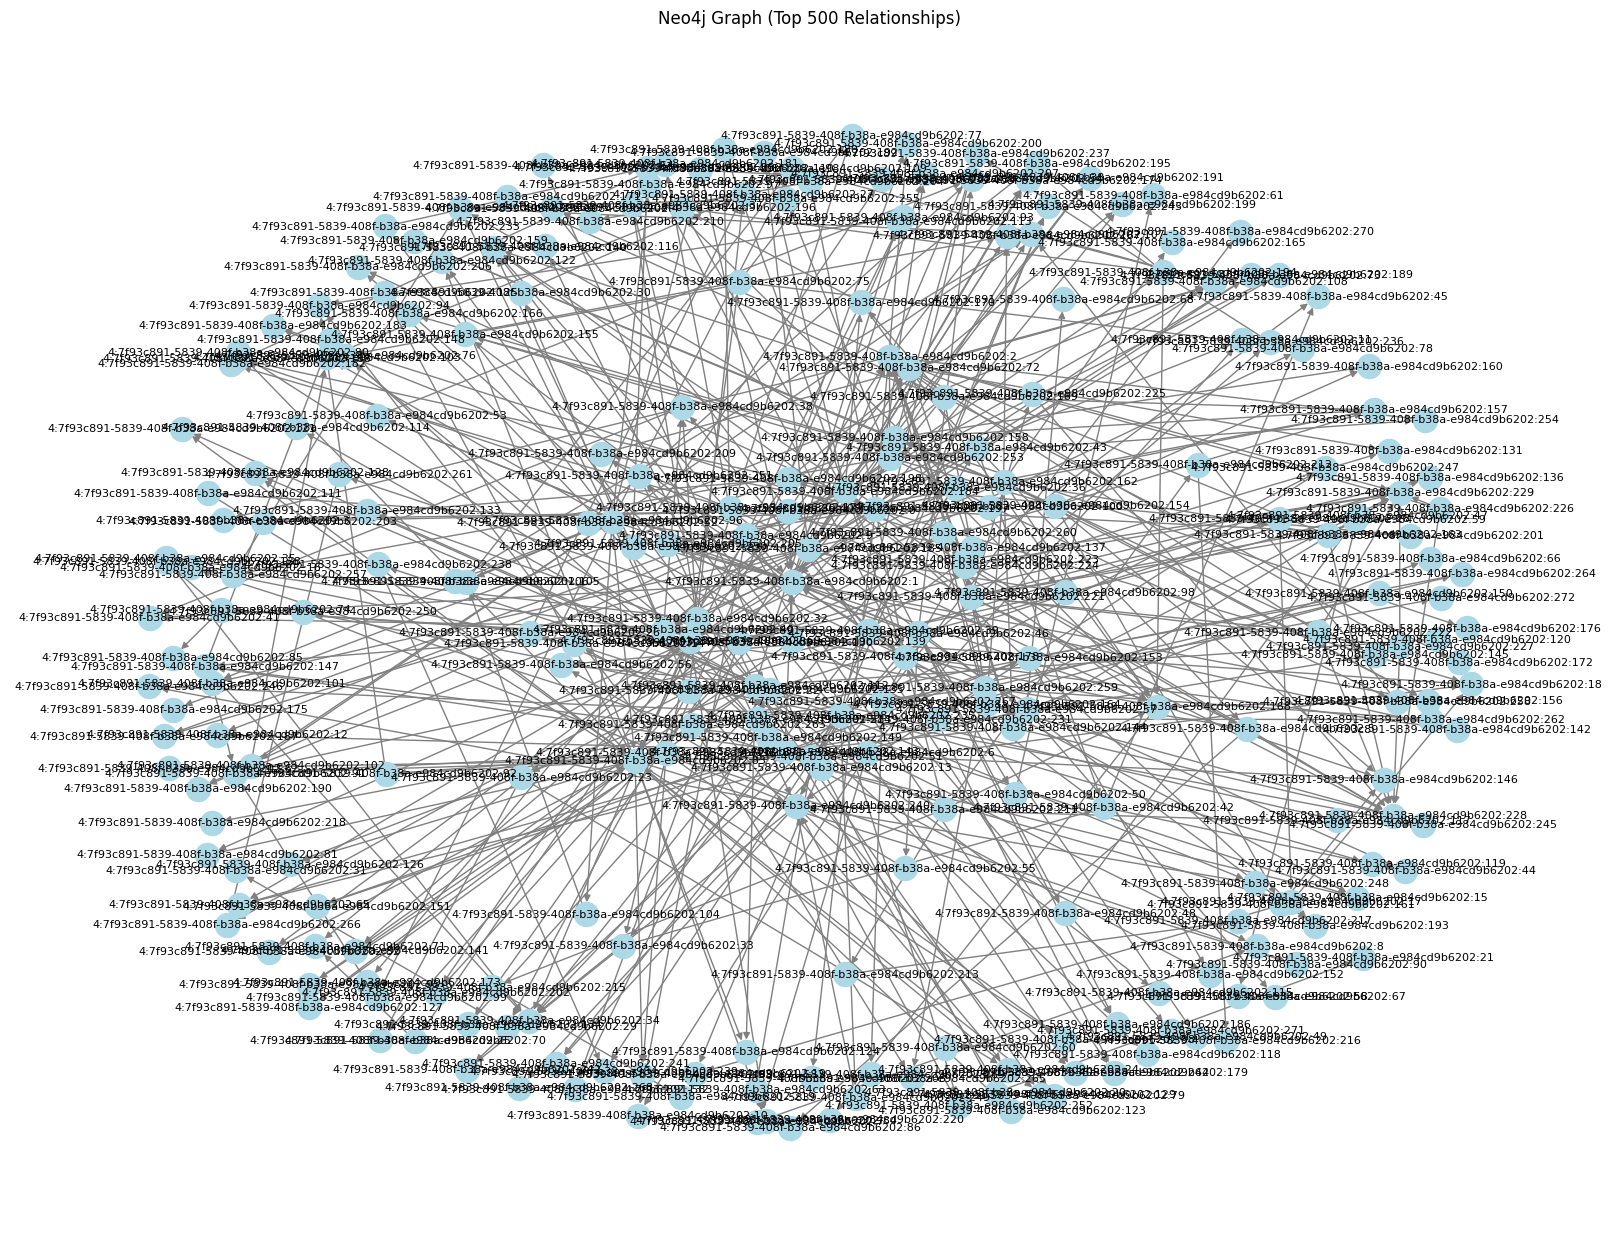

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

# Neo4j 드라이버 연결
driver = GraphDatabase.driver(uri, auth=(user, password))

# 빈 NetworkX DiGraph 생성
G = nx.DiGraph()

# 세션 실행 및 데이터 적재
with driver.session() as session:
    result = session.run("MATCH (s)-[r]->(t) RETURN s, r, t LIMIT 500")
    
    for record in result:
        s = record["s"]
        t = record["t"]
        r = record["r"]

        s_id = s.element_id
        t_id = t.element_id
        s_label = s.get("name") or s_id
        t_label = t.get("name") or t_id

        # 노드와 엣지 추가
        G.add_node(s_id, label=s_label)
        G.add_node(t_id, label=t_label)
        G.add_edge(s_id, t_id, label=r.type)

# 노드 라벨 추출
labels = nx.get_node_attributes(G, 'label')

# 레이아웃 및 그래프 그리기
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)  # 배치 알고리즘

nx.draw(G, pos, with_labels=False, node_size=300, node_color='lightblue', edge_color='gray', arrows=True)
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Neo4j Graph (Top 500 Relationships)")
plt.axis("off")
plt.show()


#### 리트리버(retriever) 생성

쿼리와 관련된 정보를 가져오기 위한 도구인 리트리버
- 그래프 리트리버
  - 쿼리에서 도출된 요소와 매칭되는 주변 정보를 탐색하는 역할
  - 그래프의 노드와 관계들을 활용하여, 특정 쿼리와 연관된 개체와 이웃 노드들의 정보를 검색할 수 있음
  - 즉, 쿼리 내 키워드와 매칭되는 노드를 찾고, 해당 노드와 연결된 인접 노드를 함께 검색함으로써 쿼리에 대한 구조적 정보를 얻음
  - 관계 기반의 정보 탐색이 필요할 때 유용하게 사용
- 벡터 리트리버
  - 임베딩 벡터를 기반으로 시맨틱 공간에서 유사한 그래프 데이터를 탐색
  - 단어 수준의 키워드 매칭에 국한되지 않고 문장 및 문서의 의미적 유사성을 기반으로 검색 결과를 제공
  - 의미적 유사성에 기반한 검색 제공

##### 그래프 리트리버

In [13]:
# 먼저 자연어 문장에서 핵심 노드를 추출하기 위한 Entities 클래스를 선언

class Entities(BaseModel):
    """텍스트에서 명명된 개체와 주요 개념을 추출하는 모델"""
    people: list[str] = Field(
        ...,
        description="텍스트에서 언급된 사람 이름 리스트"
    )
    organizations: list[str] = Field(
        default_factory=list,
        description="텍스트에서 언급된 조직 리스트"
    )
    keywords: list[str] = Field(
        default_factory=list,
        description="텍스트에서 언급된 주요 개념이나 키워드 리스트"
    )

In [14]:
llm= ChatOpenAI(temperature=0, model="gpt-4o")
prompt = ChatPromptTemplate.from_messages(
[
        ("system",
         "당신은 자연어 처리 어시스턴트입니다. 제공된 텍스트에서 사람, 조직, 주요 개념과 같은 "
         "명명된 개체를 식별하고 추출해주세요"),
        ("human",
         "다음 텍스트에서 관련 개체들을 추출해 주세요. "
         "다음 카테고리에 맞춰 개체들을 제공해 주세요: "
         "1. 사람, 2. 조직, 3. 주요 키워드 \n\n"
         "텍스트: {question}"),
    ]
)
entity_chain = prompt | llm.with_structured_output(Entities)

/home/haiqv/conda/envs/rag/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1660: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


In [15]:
entity_chain.invoke("한국은행에서 발표한 2024년에 발표된 최근 중소 벤처 투자 관련 동향을 알려줘.")

Entities(people=[], organizations=['한국은행'], keywords=['2024년', '중소 벤처 투자', '동향'])

In [16]:
# 그래프 리트리버 함수 생성

def graph_retriever(question: str) -> str:
    """
    Collects the neighborhood of entities mentioned
    in the question
    """
    result = ""
    entities = entity_chain.invoke({"question": question})

    # names, organizations, keywords 모두를 검색에 사용
    all_entities = entities.people + entities.organizations + entities.keywords

    for entity in all_entities:
        response = graph.query(
            """
            MATCH (node)
            WHERE toLower(node.id) CONTAINS toLower($query) OR toLower(node.text) CONTAINS toLower($query)
            MATCH (node)-[r]-(neighbor)
            WHERE type(r) <> 'MENTIONS'
            RETURN CASE
                WHEN startNode(r) = node
                THEN node.id + ' - ' + type(r) + ' -> ' + neighbor.id
                ELSE neighbor.id + ' - ' + type(r) + ' -> ' + node.id
            END AS output
            LIMIT 50
            """,
            {"query": entity.lower()},
        )
        result += "\n".join([el['output'] for el in response])
        if result:
            result += "\n"  # 각 엔티티의 결과 사이에 빈 줄 추가

    return result.strip()  # 마지막 빈 줄 제거

# 사용 예
question = "저업력 중소기업이 겪는 어려움에 대해 말해줘"
print(graph_retriever(question))

벤처기업 - CATEGORY -> 저업력 중소기업
혁신기업 - CATEGORY -> 저업력 중소기업
저업력 중소기업 - 제한 -> 특허출원
혁신기업 - 중심 -> 저업력 중소기업
신생기업 - DECREASE_ENTRY -> 저업력 중소기업
저업력 중소기업 - APPLY -> 미국특허
저업력 중소기업 - HAS -> 혁신활동 저해요인
저업력 중소기업 - PATENT_APPLICATION -> 미국
Ict산업비중 - ASSOCIATED_WITH -> 저업력 중소기업
업체당 R&D - ASSOCIATED_WITH -> 저업력 중소기업
글로벌 금융위기 - AFFECTED -> 저업력 중소기업
기업수 - ASSOCIATED_WITH -> 저업력 중소기업
제조업 비중 - ASSOCIATED_WITH -> 저업력 중소기업
업체당 종업원수 - ASSOCIATED_WITH -> 저업력 중소기업
혁신기업 - 분류 -> 저업력 중소기업
저업력 중소기업 - 차지 -> 전체 혁신기업
저업력 중소기업 - 둔화 -> 생산성
저업력 중소기업 - 기간 -> 2010년대 이전
저업력 중소기업 - 증가 -> 생산성
혁신기업 - CLASSIFIED_AS -> 저업력 중소기업
저업력 중소기업 - HAS_ATTRIBUTE -> 업력하위 20%
중소기업 - FACES -> 혁신자금조달 어려움


##### 벡터 리트리버

벡터 리트리버는 Neo4j 의 Neo4jVector.from_existing_graph 메서드를 사용하여 그래프에 저장된 문서의 임베딩을 자동으로 생성하고 인덱싱한다.

In [17]:
# Neo4jVector를 이용해 벡터 인덱스 구성

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),          # OpenAI 임베딩 모델 사용
    search_type="hybrid",        # 키워드 + 벡터 검색 방식 사용
    node_label="Document",       # 검색 대상 노드 레이블
    text_node_properties=["text"], # 벡터화할 텍스트 속성
    embedding_node_property="embedding", # 임베딩 저장 속성
    url=uri,
    username=user,
    password=password
)
vector_retriever = vector_index.as_retriever()

In [18]:
# Cypher 쿼리 실행

query = """
MATCH (n:Document)
RETURN n.embedding AS embedding, properties(n) AS all_properties
LIMIT 1;
"""
result = graph.query(query)
print(result)

[{'embedding': [-0.00538697699084878, -0.03745231777429581, -0.005336347501724958, -0.033563971519470215, 0.001401592860929668, 0.008755525574088097, -0.010915716178715229, 0.002199007198214531, -0.01923920400440693, 0.004627534653991461, -0.0002225587668363005, 0.02466668374836445, -0.014203257858753204, -0.008721772581338882, -0.010362167842686176, 0.019104192033410072, 0.017754072323441505, -0.03483308479189873, 0.0015391362830996513, -0.01640395261347294, -0.012124073691666126, 0.0004484928213059902, 0.007135381922125816, -0.01253585983067751, 0.0053532239980995655, 0.014446279034018517, 0.019630737602710724, -0.024059129878878593, -0.00809396617114544, 0.011651531793177128, -0.0031508414540439844, -0.0031474661082029343, 0.001780470134690404, 0.0007134538027457893, -0.0017095889197662473, -0.011982310563325882, 0.0032807905226945877, -0.004489147569984198, 0.023991623893380165, -0.016687477007508278, -0.0005700035835616291, 0.003268976928666234, 0.009093055501580238, 0.00670671882

In [19]:
vector_retriever.invoke("저업력 중소기업이 겪는 어려움에 대해 말해줘")

[Document(metadata={}, page_content='\ntext: 중소기업은 법령상 기준에 따른 분류가 아님에 유의 \n12. 이처럼 2010년대 들어 혁신기업의 생산성이 더 크게 둔화된 배경을 보다 자세\n히 살펴보기 위해 혁신기업을 규모 및 업력에 따라 ① 대기업 , ② 고업력 중소기업 , \n③ 저업력 중소기업 등으로 구분해보았다 (그림 2.4).선행연구는규모가큰기업일수\n록R&D고정비용및투자위험부담능력 ,다양한상품군을통한혁신실적의활용도'),
 Document(metadata={}, page_content='\ntext: 2060100140180\n01년 06년 11년 16년 21년1,000명이상\n300~999 명\n300명미만(업체당 , 11년=100) (업체당 , 11년=100)\n주: 1)혁신기업이 아닌 전체 기업 대상으로 구분\n자료: 한국기업혁신조사 원시자료자료: 연구개발활동조사\n18. 또한 혁신잠재력을 갖춘 신생기업의 진입이 줄면서 저업력 중소기업이 빠르게 \n고령화되고 있다.저업력중소기업중에서설립후8년내에미국특허를출원한신'),
 Document(metadata={}, page_content='\ntext: 전체 기업을 대상으로 저업력 중소기업을 구분하였다 .\n15)업력이 높을수록 특허출원 가능성이 높아지는 점을 고려하여 설립 후 8년 이내 특허 출원으로 제한하였다 .혁신 역량을 갖춘 신생기업의 진입이 감소 저업력 중소기업을 중심으로 혁신기업이 고령화\n[그림2.15] 설립 후 8년 내 특허출원1) 신생기업 비중 [그림2.16] 혁신에 따른 기업분류별 업력\n01020304050\n01020304050'),
 Document(metadata={}, page_content='\ntext: 을보일뿐만아니라2010년들어상대적으로빠르게증가하고있다(그림 2.5).또한\n혁신기업중에서설립후5년이하중소기업의생산성이여타기업들에비해가파\n르게높아지는모습이다(그림 2.6).이러한점을고려해전체혁신기업중에서매년\n종업원수기준상위 5%기업을 ｢대기

##### 풀 리트리버 (full retriever)

그래프 리트리버와 벡터 리트리버를 결합

In [20]:
def full_retriever(question: str):
    # 그래프 리트리버를 통해 연관 노드, 관계 Rag 데이터 수집
    graph_data = graph_retriever(question)

    # 벡터 리트리버를 통해 의미적으로 유사한 Rag 데이터 수집
    vector_data = [doc.page_content for doc in vector_retriever.invoke(question)]

    # 최종 출력 형식을 개선하여 가독성을 높임
    final_data = f"""
--- 검색 결과 ---

[Graph Data]
{graph_data if graph_data else "관련된 그래프 데이터가 없습니다."}

[Vector Data]
{("# Document ".join(vector_data) if vector_data else "관련된 벡터 데이터가 없습니다.")}
"""
    return final_data.strip()

In [21]:
template = """ Use the following context as a primary reference to answer the question:
{context}

Question: {question}
Use natural language and be concise.
Answer:"""

# 프롬프트 템플릿 설정
prompt = ChatPromptTemplate.from_template(template)

# 체인 구성
chain = (
    {
        "context": lambda question: full_retriever(question),  # `full_retriever` 결과를 context로 사용
        "question": RunnablePassthrough()  # 질문 그대로 전달
    }
    | prompt
    | llm  # LLM을 사용하여 최종 응답 생성
    | StrOutputParser()  # 출력 파싱
)

In [22]:
chain.invoke(input="저업력 중소기업이 겪는 어려움에 대해 말해줘")

'저업력 중소기업은 혁신 자금 조달의 어려움을 겪고 있으며, 혁신 활동을 저해하는 요인들이 존재합니다. 또한, 이들 기업은 특허 출원에 제한이 있으며, 생산성 둔화 문제도 겪고 있습니다. 글로벌 금융위기와 같은 외부 경제적 충격에도 취약한 상태입니다.'

## 마무리

기존의 다른 RAG 방법론들에 비해 GraphRAG 는 텍스트 간의 관계와 연결성을 기반으로 정보를 구성하기 때문에 문서 내 정보가 서로 어떻게 연결되어 있는지에 대한 정보를 제공한다는 점에서 강점을 지니고 있다.

이는 단순히 개별적인 정보를 나열하는 데 그치지 않고, 정보를 문맥과 관계를 통해 분석하기에 LLM이 추론할 수 있는 기반을 더 많이 제공한다.